# SINDy - 1D PDEs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from math import pi
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField
from my_functions import *

In [2]:
a = 1  # wave speed
b = 0.1  # diffusivity
solution_name = "u"
equation = PDE({solution_name: f"- {a} * d_dx(u) + {b} * laplace(u)"},
                # bc={"value": "cos(x)"}
                )

x_min = -pi
x_max = pi
x_num_elements = 256
dx = (x_max - x_min)/x_num_elements

grid = CartesianGrid([[x_min, x_max]], [x_num_elements], periodic=True)
state = ScalarField.from_expression(grid, "sin(x)+cos(2*x)")

t_max = pi
t_num_elements = 256
dt = t_max/t_num_elements

storage = MemoryStorage()
result = equation.solve(state, t_range=t_max, tracker=storage.tracker(t_max/t_num_elements))

x = np.ravel(storage.grid.axes_coords)
t = np.ravel(storage.times)

In [3]:
u = np.real(storage.data)

In [4]:
def plot_solution(x, t, u, main_str):
    plt.figure()
    plt.pcolormesh(x, t, u)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('t', fontsize=16)
    plt.title(main_str, fontsize=16)
    plt.colorbar()

def plot_derivatives(x, t, u, solution_name):

    for axis, (label, v, n) in enumerate(zip(["t", "x"], [t, x], [1, 2])):
        dv = v[1] - v[0]
        for d in range(1, 1+n):
            u_i = ps.FiniteDifference(d=d, axis=axis)._differentiate(u, t=dv)
            suffix = label*d
            plot_solution(x, t, u_i, f"${solution_name}_{{{suffix}}}$")

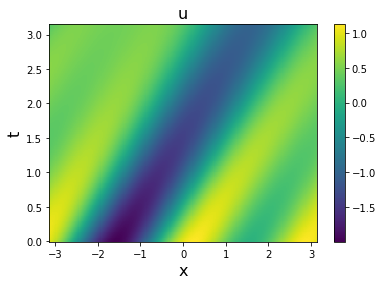

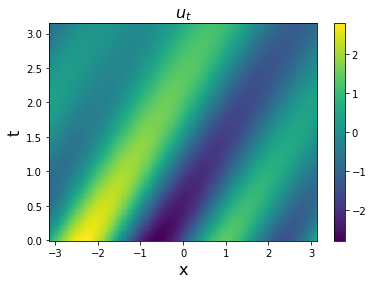

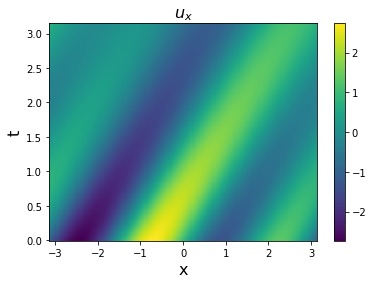

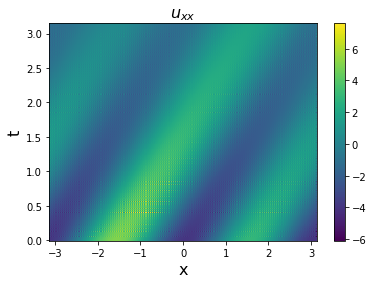

In [5]:
plot_solution(x, t, u, solution_name)
plot_derivatives(x, t, u, solution_name)

In [6]:
X, T = np.meshgrid(x, t, indexing="ij")
spatiotemporal_grid = np.asarray([X, T])
spatiotemporal_grid = np.transpose(spatiotemporal_grid, axes=[1,2,0])
H_xt = [dx/2, dt/2]
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

def get_model(threshold):
    pde_lib = ps.PDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2, spatial_grid=x, 
                            include_bias=True, is_uniform=True
                            )
    optimizer=ps.STLSQ(threshold=threshold, alpha=1e-5, normalize_columns=True)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=solution_name)
    return(model)

def get_weak_model(threshold, num_domain_centers):
    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=2,
        spatiotemporal_grid=spatiotemporal_grid,
        K=num_domain_centers,
        H_xt=H_xt,
        include_bias=True,
        is_uniform=False
    )

    optimizer = ps.SR3(threshold=threshold, thresholder="l0", max_iter=10000, normalize_columns=True, tol=1e-10)

    model = ps.SINDy(feature_library=pde_lib, feature_names=[solution_name], optimizer=optimizer)
    return(model)

### Clean data, normal SINDy

In [7]:
model = get_model(15)
u_r = np.transpose(u).reshape(len(x), len(t), 1)
model.fit(u_r, t=dt)
print_result(model, solution_name, "STLSQ")

Feature library:
['1', 'u', 'uu', 'u_x', 'u_xx', 'uu_x', 'uuu_x', 'uu_xx', 'uuu_xx']
STLSQ model:
(u)' = -1.000 u_1 + 0.096 u_11


 ### Noisy data, normal SINDy

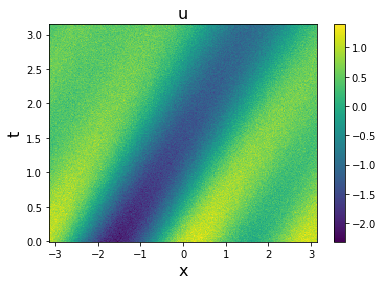

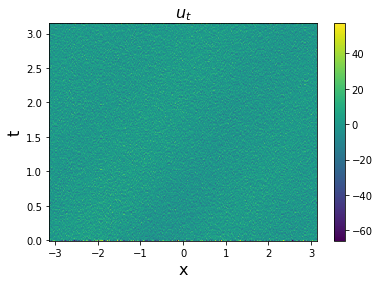

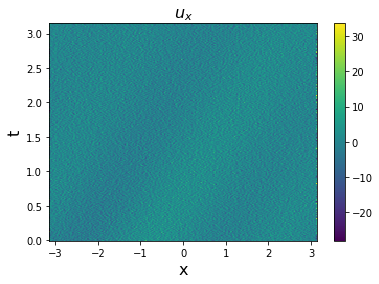

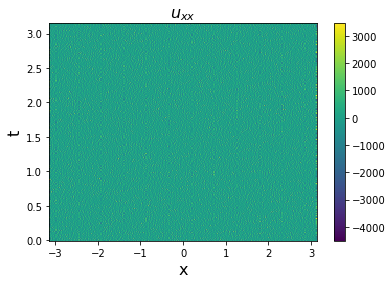

In [8]:
sd = 0.1
u_noisy = noisify(u, 0.1)
plot_solution(x, t, u_noisy, solution_name)
plot_derivatives(x, t, u_noisy, solution_name)

In [9]:
model_noisy = get_model(8)
u_r_noisy = np.transpose(u_noisy).reshape(len(x), len(t), 1)
model_noisy.fit(u_r_noisy, t=t[1]-t[0])
print_result(model_noisy, solution_name, "STLSQ")

Feature library:
['1', 'u', 'uu', 'u_x', 'u_xx', 'uu_x', 'uuu_x', 'uu_xx', 'uuu_xx']
STLSQ model:
(u)' = -0.184 u + -0.162 u_1 + 0.134 uu_1 + 0.093 uu_11


 ### Clean data, weak SINDy

In [10]:
weak_model = get_weak_model(0.0001, 100)
weak_model.fit(u_r)
print_result(weak_model, solution_name, "SR3 weak")

Feature library:
['1', 'u', 'uu', 'u_x', 'u_xx', 'uu_x', 'uuu_x', 'uu_xx', 'uuu_xx']
SR3 weak model:
(u)' = -0.979 u_1


### Noisy data, weak SINDy

In [11]:
weak_model_noisy = get_weak_model(0.0005, 100)
weak_model_noisy.fit(u_r_noisy)
print_result(weak_model_noisy, solution_name, "SR3 weak")

Feature library:
['1', 'u', 'uu', 'u_x', 'u_xx', 'uu_x', 'uuu_x', 'uu_xx', 'uuu_xx']
SR3 weak model:
(u)' = -1.933 1 + 1.491 uu + -0.005 u_11 + 0.003 uuu_11
